In [ ]:
!pip install multidict

     |████████████████████████████████| 160 kB 4.7 MB/s 


In [ ]:
!pip install -U yellowbrick

In [ ]:
!pip install mpld3

     |████████████████████████████████| 201 kB 5.2 MB/s 


# Ne pas oublier de relancer l'environnement

In [ ]:
from google.colab import files

# Si le dossier est déjà monté dans l'environnement d'exécution, on passe
try:
  !git clone https://github.com/Patent2net/DistorsionCom.git
  os.chdir('DistorsionCom')
except:
  print("Dossier déjà monté, vous pouvez continuer l'exécution")


fatal: destination path 'DistorsionCom' already exists and is not an empty directory.
Dossier déjà monté, vous pouvez continuer l'exécution


In [ ]:
stockageEntree = "/content/DistorsionCom/OUT"
stockageSortie = "/content/DistorsionCom/OUT" # ce notebook ne sauvegarde que peu de choses. par ex. plt.savefig(stockageSortie + "/legendeTypSites2.png")


---
Personnalisation

NE PAS EXECUTER.

> sauf à vouloir personnaliser et travailler sur d'autres données



> Ces cellules permettent de réaliser les traitements à partir de son propre espace de stockage. A n'exécuter que dans ce cas en adaptant les dossiers d'entrée et sortie.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Récupérer les sorties sur son drive (créer un dossier "OUT")
stockageSortie = "/content/drive/MyDrive/OUT"

In [ ]:
# Récupérer les entrées sur son drive
stockageEntree = "/content/drive/MyDrive/OUT"

---

In [ ]:
import multidict as multidict

In [ ]:
import pandas as pd
import os, pickle
import pprint as pp
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
import matplotlib_inline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.parse as parse
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from os import path
import pickle
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from matplotlib.patches import Patch #NEW
from matplotlib import cm, colors
from urllib import parse as parse
import mpld3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpld3 import plugins
from sklearn.manifold import TSNE
import matplotlib
from mpld3 import utils

css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""


class ClickInfo(mpld3.plugins.PluginBase):
    """mpld3 Plugin for getting info on click
    Comes from:
        http://stackoverflow.com/a/28838652/814354
    """

    JAVASCRIPT = """
    mpld3.register_plugin("clickinfo", ClickInfo);
    ClickInfo.prototype = Object.create(mpld3.Plugin.prototype);
    ClickInfo.prototype.constructor = ClickInfo;
    ClickInfo.prototype.requiredProps = ["id", "urls"];
    function ClickInfo(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    ClickInfo.prototype.draw = function(){
        var obj = mpld3.get_element(this.props.id);
        urls = this.props.urls;
        obj.elements().on("mousedown",
                          function(d, i){
                            window.open(urls[i], '_blank')});
    }
    """
    def __init__(self, points, urls):
        self.points = points
        self.urls = urls
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None
        self.dict_ = {"type": "clickinfo",
                      "id": mpld3.utils.get_id(points, suffix),
                      "urls": urls}

In [ ]:
#%matplotlib inline

In [ ]:
os.chdir("DistorsionCom")

In [ ]:
from outils import makeImage, clean, Palette, NettoieLabels, isPartner 

# Chargement des données de référence

## Stats

In [ ]:
stats = dict()
for ndf in os.listdir(stockageEntree +"/ContenusSites/"):
  if not ndf.startswith('.')  and "backlinks" not in ndf and 'stats' not in ndf :
    fichierEntree = stockageEntree +'/ContenusSites/' +ndf
    with open(fichierEntree, 'rb') as  fictemp: #pour ouvrir les contenus 
      soup = pickle.load(fictemp)
    index = list([url for url in soup.keys()])

    data  = [len(soup[url]) for url in index ]
    donnees = pd.DataFrame.from_dict(data)
    donnees.index = index
    donnees.columns=["taille"]
    stats [ndf]  = donnees.describe()

 # stats contient la description statistique des données fondée sur la taille
 # de celle-ci. Cette variable servira a exclure les url dont la variation
 # à la moyenne est trop importante : trop ou pas assez sont considérés comme
 # des singularités. Cela peut provenir de la forme choisie pour la page (grande
 # page qui contient "tout" avec un ascenceur interminable ou page composée
 # par des appels url en js que le collecteur ne reconstruit pas) 

In [ ]:
stats

In [ ]:
soup.keys()

dict_keys(['http://la-seyne.fr', 'http://le-pradet.fr', 'http://isere.fr', 'http://hyeres.fr', 'http://ville-lagarde.fr', 'http://toulon.fr', 'http://carqueiranne.fr', 'http://villedelacrau.fr'])

## Sites de référence

### Toutes les données

In [ ]:
import json
with open(stockageEntree + '/Ressources/Sites.json', 'r', encoding='utf-8') as f:
    CatSites = json.load(f)

In [ ]:
fichierEntree = stockageEntree +'/ContenusTraites/' +"verbesSites.pkl"
with open (fichierEntree, 'rb') as  fictemp: #on récupère tous les contenus dans pickle
  Refverbes = pickle.load(fictemp)

fichierEntree = stockageEntree +'/ContenusTraites/' +'nomsSites.pkl'
with open (fichierEntree, 'rb') as  fictemp: #on récupère tous les contenus dans pickle
  Refnoms = pickle.load(fictemp)

fichierEntree = stockageEntree +'/ContenusTraites/' +'adjectifsSites.pkl'
with open (fichierEntree, 'rb') as  fictemp: #on récupère tous les contenus dans pickle
  Refadjectifs = pickle.load( fictemp)

fichierEntree = stockageEntree +'/ContenusTraites/' +'spacySites.pkl'
with open (fichierEntree, 'rb') as  fictemp: #on récupère tous les contenus dans pickle
  RefdicoEtiquettage = pickle.load(fictemp)

In [ ]:
RefdicoEtiquettage .keys()

dict_keys(['oTourism', 'Gouv', 'parcs', 'organisations', 'Services', 'Hebergement', 'restauration', 'locations', 'mairies'])

## Partenaires



In [ ]:
fichierEntree = stockageEntree +'/ContenusTraites/' +"Partners.pkl"
with open (fichierEntree, 'rb') as  fictemp: #on récupère tous les contenus dans pickle
  PartnersdicoEtiquettage = pickle.load(fictemp)

In [ ]:
PartnersParCat = dict()
for url in PartnersdicoEtiquettage .keys():
  for cat in CatSites .keys():
    if isPartner(url, CatSites[cat][0]):
      if cat in PartnersParCat .keys():
        PartnersParCat[cat].append(url)
      else:
        PartnersParCat[cat] = [url]

In [ ]:
PartnersParCat .values()

dict_values([['http://ofb.gouv.fr', 'http://ecologique-solidaire.gouv.fr'], ['http://hyeres-tourisme.com', 'http://ramatuelle-tourisme.com', 'http://lepradet-tourisme.fr', 'http://provence-alpes-cotedazur.com', 'http://visitvar.fr'], ['http://tlv-tvm.com', 'http://bateauxverts.com', 'http://lesbateliersdelarade.com', 'http://vedettesilesdor.fr', 'http://bateliersdelacotedazur.com', 'http://latitudeverte.fr', 'http://bateauxsaintraphael.com', 'http://reseaumistral.com'], ['http://bateaux-taxi.com'], ['http://sanctuaire-pelagos.org'], ['http://villanoailles-hyeres.com'], ['http://ville-lagarde.fr']])

In [ ]:
PartnersdicoEtiquettage .keys()

dict_keys(['http://fr-fr.facebook.com/pages', 'https://fr-fr.facebook.com/pages', 'http://alizee-soft.com', 'http://pyrenees-parcnational.fr', 'http://guadeloupe-parcnational.fr', 'http://calanques-parcnational.fr', 'http://ecrins-parcnational.fr', 'http://colleo.fr', 'http://cevennes-parcnational.fr', 'http://espritparcnationalportcros.com', 'https://espritparcnationalportcros.com', 'http://forets-parcnational.fr', 'http://ofb.gouv.fr', 'http://parcsnationaux.fr', 'http://portcrosparcnational.fr', 'http://mercantour.eu', 'http://reunion-parcnational.fr', 'http://parc-amazonien-guyane.fr', 'http://www.var.gouv.fr', 'http://vanoise-parcnational.fr', 'http://www.vanoise-parcnational.fr', 'https://vanoise-parcnational.fr', 'https://www.vanoise-parcnational.fr', 'http://espritparcnational.com', 'http://ac-nice.fr', 'http://premar-mediterranee.gouv.fr', 'http://hyeres-tourisme.com', 'http://festival-galathea.com', 'http://tlv-tvm.com', 'http://bateauxverts.com', 'http://www.bateauxverts.com

In [ ]:
PartnersdicoEtiquettage 

In [ ]:
from urllib import parse
lstSite, dnsStite =[], []
SiteAExclure = ['http://fr-fr.facebook.com/pages', 'https://fr-fr.facebook.com/pages', ]
for url in PartnersdicoEtiquettage .keys():
  if url not in SiteAExclure:
    urlP = parse.urlparse(url)
    lstSite .append(urlP.scheme + '://' + urlP.hostname)
    dnsStite .append(urlP.hostname)


In [ ]:
fait, retenu =[],[]
for url in PartnersdicoEtiquettage .keys():
  if url not in SiteAExclure:
    urlP = parse.urlparse(url)
    if dnsStite.count(urlP.hostname) >1:
      if urlP.hostname not in fait:
        retenu .append(urlP.scheme + '://' + urlP.hostname)
        fait .append(urlP.hostname)
      else:
        pass
    else:
      retenu .append(urlP.scheme + '://' + urlP.hostname)
      fait .append(urlP.hostname)

In [ ]:
retenu

In [ ]:
CatSitesPropre =[]

for typ in CatSites .keys():
  for url in CatSites [typ] [0]:
    urlP = parse.urlparse(url)
    CatSitesPropre .append(urlP.hostname)
    CatSitesPropre .append(urlP.hostname .replace('www.', ''))
    CatSitesPropre .append(urlP.scheme + '://' + urlP.hostname)
    if 's' not in urlP.scheme:
      CatSitesPropre .append(urlP.scheme + 's://'+ urlP.hostname)
    else:
      CatSitesPropre .append('http://'+ urlP.hostname)

In [ ]:
CatSites ["parcs"]

In [ ]:
partnersSansTyp = [url for url in retenu if url not in CatSitesPropre and parse.urlparse(url).hostname not in CatSitesPropre]

In [ ]:
partnersSansTypEtiquettage, partnersAvecTypEtiquettage = dict(), dict()
for url in PartnersdicoEtiquettage .keys():
  if url in partnersSansTyp and url not in SiteAExclure:
    partnersSansTypEtiquettage [url] = PartnersdicoEtiquettage [url]
  elif url not in SiteAExclure:
    partnersAvecTypEtiquettage [url] = PartnersdicoEtiquettage [url]

In [ ]:
# Ajout des classes partenaires (ceux qui sont inclus dans la typologie et les autres)
RefdicoEtiquettage ["partnersSansTyp"] = dict()
RefdicoEtiquettage ["partnersAvecTyp"] = dict()
for url in partnersSansTypEtiquettage.keys():
  for cat in partnersSansTypEtiquettage [url] .keys():
    if cat in RefdicoEtiquettage ["partnersSansTyp"] .keys():
      RefdicoEtiquettage ["partnersSansTyp"][cat] .extend(partnersSansTypEtiquettage [url][cat])
    else:
      RefdicoEtiquettage ["partnersSansTyp"][cat] = partnersSansTypEtiquettage [url][cat]

for url in partnersAvecTypEtiquettage.keys():
  for cat in partnersAvecTypEtiquettage [url] .keys():
    if cat in RefdicoEtiquettage ["partnersAvecTyp"] .keys():
      RefdicoEtiquettage ["partnersAvecTyp"][cat] .extend(partnersAvecTypEtiquettage [url][cat])
    else:
      RefdicoEtiquettage ["partnersAvecTyp"][cat] = partnersAvecTypEtiquettage [url][cat]

## Communs et 𝚫





> séparation des spécificités lexicales par typologie de sites.

In [ ]:
CountMots = dict()
for ndf in RefdicoEtiquettage .keys():
  CountMots[ndf] =dict()
  for cat in RefdicoEtiquettage[ndf] .keys():
    CountMots[ndf][cat] = Counter (RefdicoEtiquettage[ndf][cat])



In [ ]:
# version cibléee sur les caractères alpha
CountMots2 = dict()
for ndf in RefdicoEtiquettage.keys():
  CountMots2[ndf] = dict()
  for cat in CountMots2[ndf] .keys():
    CountMots2[ndf][cat] = {mot:CountMots[ndf][cat][mot] for mot in CountMots[ndf][cat].keys() if mot.isalpha() or '-' in mot}

In [ ]:
CountMots =CountMots2

In [ ]:
CountMotsParners = dict()
for ndf in partnersAvecTypEtiquettage .keys():
  CountMotsParners[ndf] =dict()
  for cat in partnersAvecTypEtiquettage[ndf] .keys():
    CountMotsParners[ndf][cat] = Counter (partnersAvecTypEtiquettage[ndf][cat])



In [ ]:
partnersAvecTypEtiquettage[ndf][cat]

['plus', 'plus']

In [ ]:
CountMotsParners[ndf]

In [ ]:
# version cibléee sur les caractères alpha
CountMotsParners2 = dict()
for ndf in partnersAvecTypEtiquettage.keys():
  CountMotsParners2[ndf] = dict()
  for cat in CountMotsParners[ndf] .keys():
    CountMotsParners2[ndf][cat] = dict()
    for mot in CountMotsParners[ndf][cat].keys():
       if mot.isalpha() or '-' in mot:
          CountMotsParners2[ndf][cat][mot] =  CountMotsParners[ndf][cat][mot]

In [ ]:
CountMotsParners = CountMotsParners2

### Séparation des termes
> 3 blocs séparés dans 3 variables distinguant les catégories grammaticales : 

1. les mots communs à toutes les catégories de sites (mots bateaux) :  *communsExclusifs*

2. les mots communs à deux catégories de sites : *communs*

3. les mots exclusifs à chaque catégorie de site : *diff*

In [ ]:
def clean(terme, aExclure):
  if len(terme)<3 or terme .lower() in aExclure:
    return False
  elif terme.isalpha():
    return True
  elif '-' in terme and not terme.startswith('-'):
    terme = terme.replace("-", "")
    if terme.isalpha():
      return True
    else:
      return False
  else:
    return False 


In [ ]:
aExclure = []

In [ ]:
catGram = ["VERB", "ADJ", "ADV", "NOUN"]

In [ ]:
communsExclusifs = dict() # pour chaque catégorie, les termes communs à TOUS

for ndf in CountMots.keys():
  communsExclusifs[ndf] = dict()

for ndf in CountMots.keys():
  autres = list(CountMots.keys())
  autres.remove(ndf) 
  for cat in catGram:
    # initialisation
    communsExclusifs[ndf][cat] = set(CountMots[ndf][cat].keys()).intersection(set(CountMots[autres [0]][cat].keys()))
  for cat in catGram:
    for ens in autres:
      #print (ndf, '  ', ens, '  ',cat, '  ',len(CountMots [ens][cat].keys()))
      communsExclusifs[ndf][cat] = communsExclusifs[ndf][cat].intersection(set(CountMots[ens][cat].keys()))
  for cat in catGram:   # nettoyage
    communsExclusifs[ndf][cat] = [truc for truc in communsExclusifs[ndf][cat] if clean(truc, aExclure)]
    #print(len (communsExclusifs [ndf][cat]))

In [ ]:
communs = dict() # pour chaque catégorie, les termes communs à au moins deux

for ndf in CountMots.keys():
  communs[ndf] = dict()

for ndf in CountMots.keys():
  autres = list(CountMots.keys())
  autres.remove(ndf) 
  for cat in catGram:
    # initialisation
    communs[ndf][cat] = set()
  for cat in catGram:
    for ens in autres:
      communs[ndf][cat] = communs[ndf][cat] .union(set(CountMots[ndf][cat].keys()) .intersection(set(CountMots[ens][cat].keys())))
      #print (ndf, '  ', ens, '  ',cat, '  ',len(CountMots [ens][cat].keys()), len(communs [ndf][cat]))
# on évite aussi ceux qui sont communs à tous retrouvés précédemment
for ndf in CountMots.keys():  
  for cat in catGram:
    #print(len (communs [ndf][cat]))
    communs[ndf][cat] = [truc for truc in communs[ndf][cat] if truc not in communsExclusifs[ndf][cat] and clean(truc, aExclure)]
    #print(len (communs [ndf][cat]))

In [ ]:
communs[ndf]

In [ ]:
dicoEtiquettage['Services'].keys()

dict_keys(['MISC', 'LOC', 'PER', 'ORG', 'NOUN', 'ADV', 'ADJ', 'VERB'])

In [ ]:
CountMots[ens].keys()

dict_keys(['VERB', 'ADJ', 'ADV', 'NOUN'])

In [ ]:
diff = dict()
for ndf in CountMots.keys():
  diff[ndf] = dict()

for ndf in CountMots.keys(): 
  for cat in catGram:
    #diff [ndf] [cat] = set()
    diff[ndf][cat] = [mot for mot in CountMots[ndf][cat].keys() if mot not in communs[ndf][cat] and mot not in communsExclusifs[ndf][cat] and clean(mot, aExclure)]

In [ ]:
aExclure =['acceoter', 'ensure', 'record', 'consented', 'perform', 'sharing', 'analyze', 'helps', 'delivering', 'analyzed', 'classified', 'analyze', 'helps', 'delivering', 'month', 'plugin', 'category', 'visitor', 'crossing', 'calle', 'comment', 'cheer', 'intracomm', 'inflatabl','dimitil']

In [ ]:
for tip in diff.keys():
  print (tip, diff[tip])

In [ ]:
from outils import makeImage2, Palette

### Consistance

> spacy peut générer des erreurs de catégorisation, d'autant plus que nos textes sont extraits d'une page Web : la structure textuelle est rompue. De fait, certains termes peuvent être, selon les sites, affectés à des catégories grammaticales différentes.

Le choix est fait de les éliminer. Le code ci-dessous les affiche et les élimine

In [ ]:
# test de consistance et séparation des mots entre les différents types
# a rééxécuter deux fois
test = [mot for cle in diff.keys() for cat in catGram for mot in diff[cle][cat] if mot in communs[cle][cat]]
print(test, " <-- termes communs entre diff et communs (doit être vide)")
print(" termes communs de chaque type de site pour toute catégorie grammaticale avec n'importe quel autre type (devrait être vide)")
for cle in diff.keys():
  autres = list(diff.keys())
  autres.remove(cle)
  autresMots = [mot for key in autres for cat in catGram for mot in diff[key][cat]]
  test = [mot for cat in catGram for mot in diff[cle][cat] if mot in autresMots]
  # type de site, terme et catégorie grammaticale
  print (cle, test)
  for truc in test:
    for cat in catGram:
      for key in diff.keys():
          if truc in diff[key][cat]:
            print (cle, truc, key, cat)
            # suppression 
            diff [key][cat].remove(truc)



In [ ]:
diff.keys()

dict_keys(['oTourism', 'Gouv', 'parcs', 'organisations', 'Services', 'Hebergement', 'restauration', 'locations', 'mairies', 'partnersSansTyp', 'partnersAvecTyp'])

In [ ]:
fichierDeSortie = stockageEntree +'/ContenusTraites/' +'communs.pkl'
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(communs, fictemp)

fichierDeSortie = stockageEntree +'/ContenusTraites/' +'communsExclusifs.pkl'
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(communsExclusifs, fictemp)

fichierDeSortie = stockageEntree +'/ContenusTraites/' +'diff.pkl'
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(diff, fictemp)

In [ ]:
fichierDeSortie = stockageEntree +'/ContenusTraites/' +'communs.pkl'
with open (fichierDeSortie, 'rb') as  fictemp: #on met tous les contenus dans pickle
  communs = pickle.load(fictemp)

fichierDeSortie = stockageEntree +'/ContenusTraites/' +'communsExclusifs.pkl'
with open (fichierDeSortie, 'rb') as  fictemp: #on met tous les contenus dans pickle
  communsExclusifs = pickle.load(fictemp)

fichierDeSortie = stockageEntree +'/ContenusTraites/' +'diff.pkl'
with open (fichierDeSortie, 'rb') as  fictemp: #on met tous les contenus dans pickle
  diff = pickle.load(fictemp)


# Représentations

In [ ]:
# on génère la palette de couleurs

palette = Palette(RefdicoEtiquettage.keys()) 

In [ ]:
# on affecte les mots de chaque classe à une couleur de la palette
couleursMots = dict()
motsCouleurs = dict()
for cle in RefdicoEtiquettage.keys():
  couleursMots[colors.to_hex((palette[cle]))] = []
for cle in RefdicoEtiquettage.keys():  
  for cat in catGram:
    for mot in set(diff[cle][cat]):
      couleursMots[colors.to_hex((palette[cle]))].append(mot) # à une couleur hexa des mots
      motsCouleurs[mot] = (int(palette[cle][0]*255), int(palette[cle][1]*255), int(palette[cle][2]*255)) # à un mot une couleur RVB


In [ ]:
# légende à priori
y = 0

for cle in palette.keys():
  #print(cle, " ---> ", colors.to_hex(palette[cle]), int(palette[cle][2]))
  y += .12
  plt.text(0.5, y, cle, size=12, rotation=0,
         ha="center", va="center", color = (0+int(palette[cle][2]) , 0 +int(palette[cle][2]), 0 +int(palette[cle][2])),
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5 , 0.5 ),
                   fc=palette[cle],
                   )
         )
plt.axis("off")
plt.show()
plt.savefig(stockageSortie + "/legendeTypSites.png")

In [ ]:
RefdicoEtiquettage ["partnersAvecTyp"] .keys()

dict_keys(['LOC', 'MISC', 'ORG', 'PER', 'NOUN', 'ADJ', 'VERB', 'ADV'])

## Représentations mixant plusieurs catégories de sites sur les partenaires

> Faire varier le seul pour modifier les représentations selon les occurrences souaitées. Le seuil max évite l'occurrence la plus importante.

Remplacer la valeur de ndf pour les partenaires selon la typologie 

In [ ]:
tempo = dict()
seuil2 = 1
seuil = 20 # occurence à partir de laquelle démarrer
ndf = "partnersSansTyp" # PartnersAvecTyp 
for cat in RefdicoEtiquettage [ndf].keys():
    tempo[cat] = ""
    if cat in CountMots[ndf] .keys():
      seuil2 = max([CountMots[ndf][cat][mot] for mot in CountMots[ndf][cat]]) #seuil
      for mot in CountMots[ndf][cat].keys():
        if CountMots[ndf][cat][mot] >seuil and CountMots[ndf][cat][mot] <seuil2 and clean(mot, aExclure):
          # if cat in diff [ndf] .keys():
            # if mot in diff [ndf][cat]:
              tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
      print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    if len(tempo [cat])>0:
      makeImage(tempo[cat], palette, couleursMots)

## Focus sur le champ lexical des partenaires de la classe "location"



In [ ]:
locs = []
for url in partnersAvecTypEtiquettage .keys():
  if url in CatSites ['locations'][0]:
    print(url, 'uoupi')
    locs .append(url)

http://bateaux-taxi.com uoupi


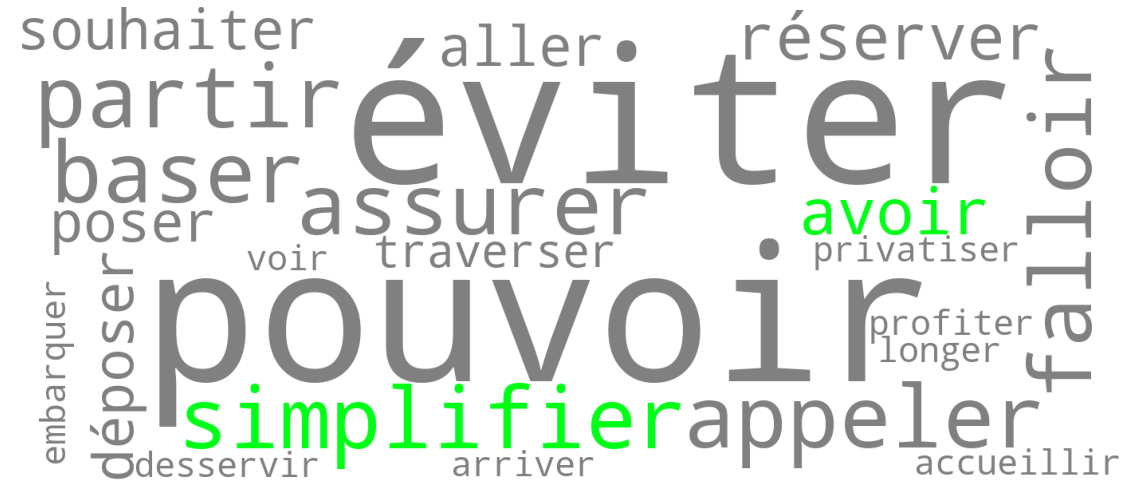

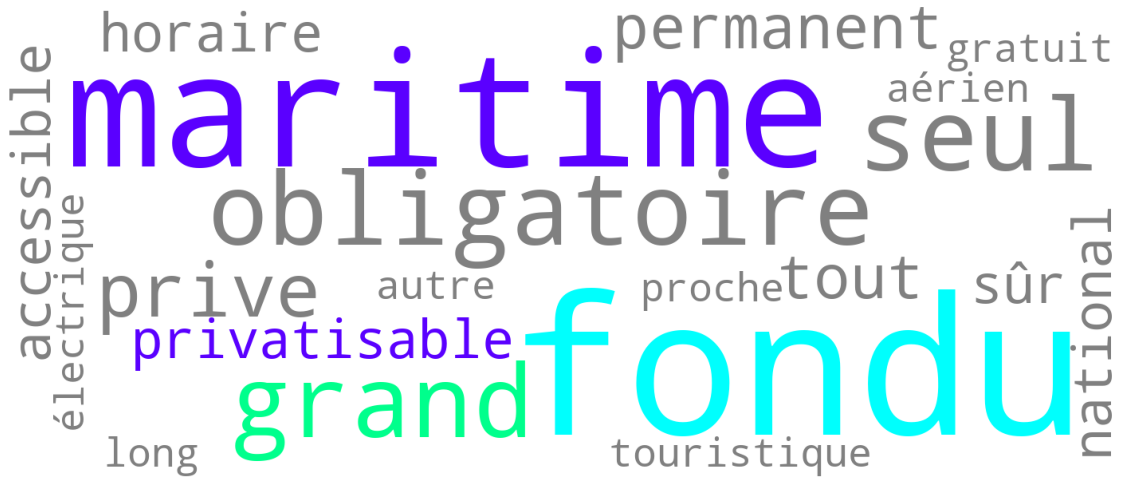

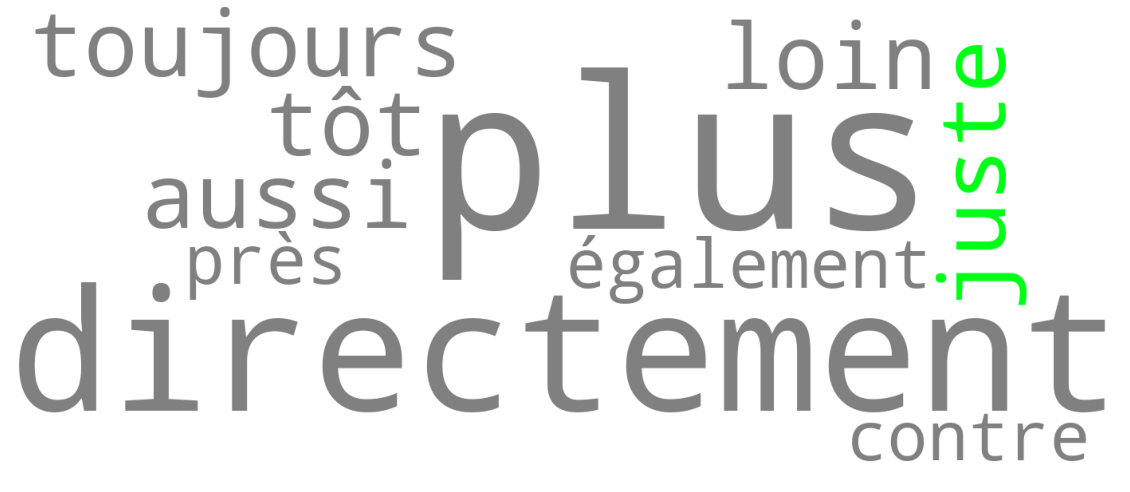

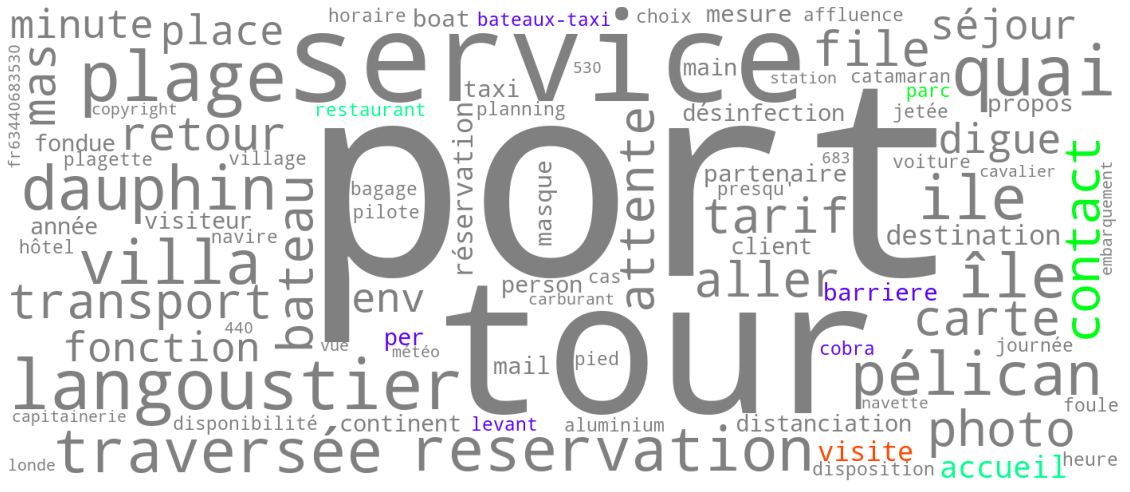

In [ ]:
for url in locs:
  for cat in catGram:

    makeImage2(Counter(partnersAvecTypEtiquettage[url][cat]), palette, couleursMots, leg = False)

In [ ]:
Counter(partnersAvecTypEtiquettage[url][cat])

## Représentations mixant plusieurs catégories de sites

> Les représentations ci-dessous n'ont pas vraiment de sens, mêlant toutes les catégories de sites qui contiennent à la fois des nombres de sites différents et très probablement des catégories de sites pas forcément optimales par leur diversité dans notre cas d'étude. 

Par ex. les classes hébergement et restauration auraient pu être séparées pour que toute entité mêlant les deux services soit vue comme relevant des deux classes. Dans le cas présent la non disjonction stricte des deux classes laisse la représentation des sites dépendante du nombre d'occurences de termes relevant d'une classe ou d'une autre sur simple effet de bord.

In [ ]:
tempo = dict()
seuil = 2 # occurence à partir de laquelle démarrer

for ndf in RefdicoEtiquettage.keys():
  for cat in catGram:
    tempo[cat] = ""
    seuil2 = max([CountMots[ndf][cat][mot] for mot in CountMots[ndf][cat]]) #seuil
    for mot in CountMots[ndf][cat].keys():
      if CountMots[ndf][cat][mot] >seuil and CountMots[ndf][cat][mot] <seuil2 and clean(mot, aExclure):
        tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
    print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    makeImage(tempo[cat], palette, couleursMots)

## Représentations sur les mots exclusifs de la catégorie

In [ ]:
aExclure += ['enjoy', 'find', 'html', 'tag', 'insert','november', 'svg', 'vsc', 'pnc', 'pag', 'anr','par', 'inselberg', 'servã', "discover", "allow", "logged", 'include', 'offer', 'receive', 'please', 'guaranteed', 'visit', 'pay', 'keep', 'submit', 'stay', 'remove', 'enter', 'emitted', 'authenticate', 'see', 'rès', 'xvi', 'xix', 'border', "per", "app", "disabl", "png", "xvii", 'est' ]
aExclure += ['wer', "chosen", 'turn', 'build', 'back', "diã", "observed", "save", "animã", "amã", "destinã", 'visited', 'furnished', 'gue', "saved", "try", "enter"]

In [ ]:
tempo = dict()
seuil = 0 # occurence à partir de laquelle démarrer
for ndf in RefdicoEtiquettage.keys():
  for cat in catGram:
    tempo[cat] = ""
    for mot in CountMots[ndf][cat].keys():
      if CountMots[ndf][cat][mot] >seuil  and mot in diff[ndf][cat] and clean(mot, aExclure):
        tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
    print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    if len(tempo[cat])>0:
      makeImage(tempo[cat], palette, couleursMots)
    else:
      print ('vide')

Output hidden; open in https://colab.research.google.com to view.

## Représentations mixant plusieurs catégories de sites

VERB
ADJ
ADV
NOUN


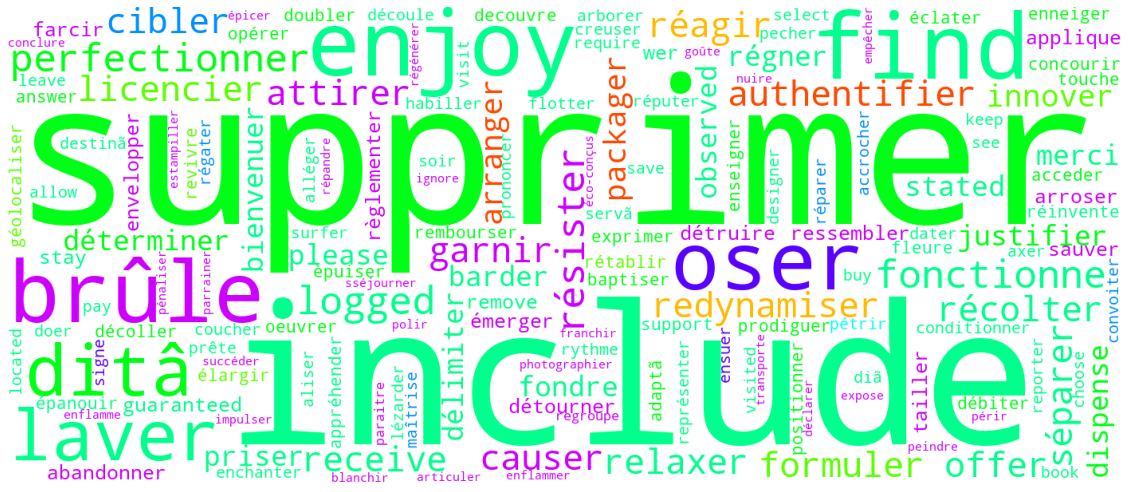

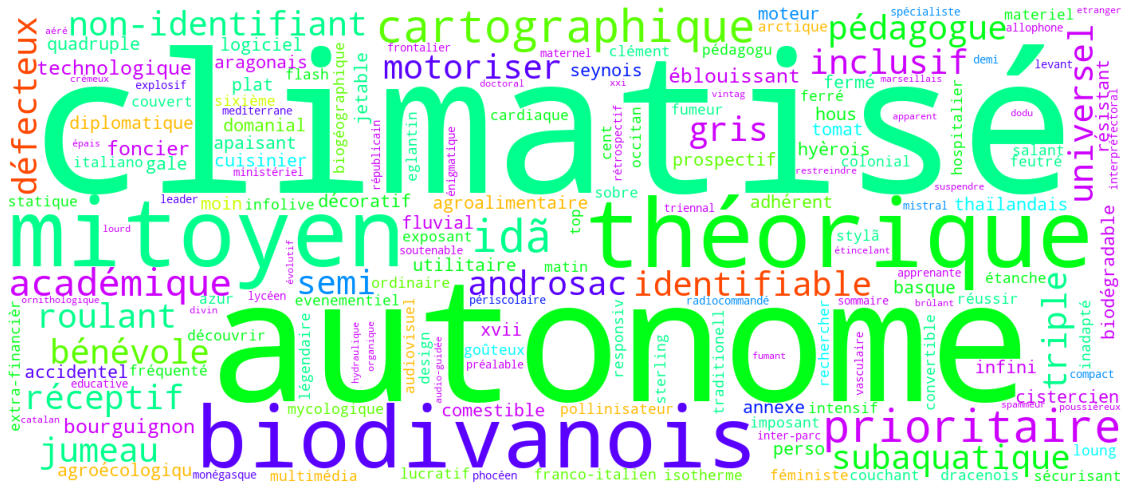

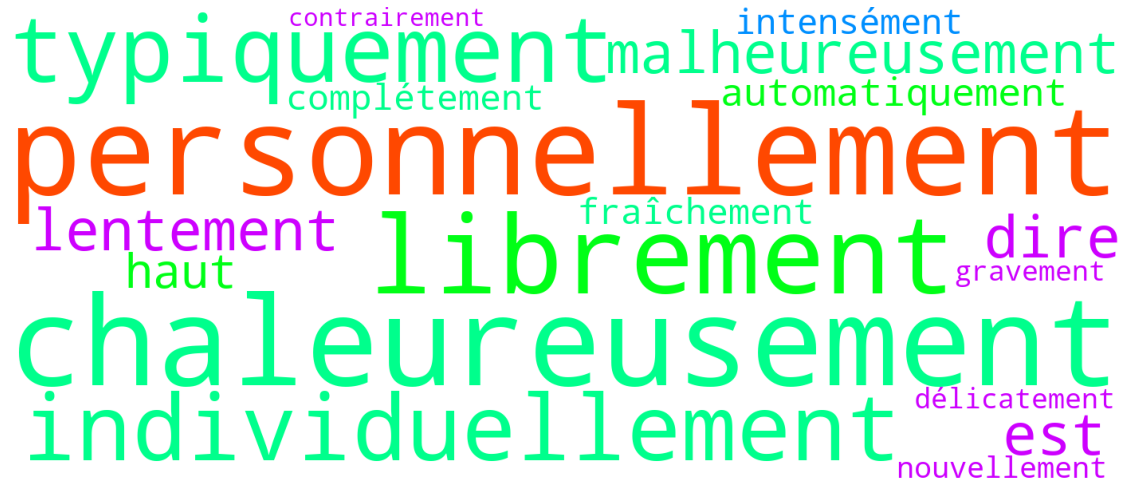

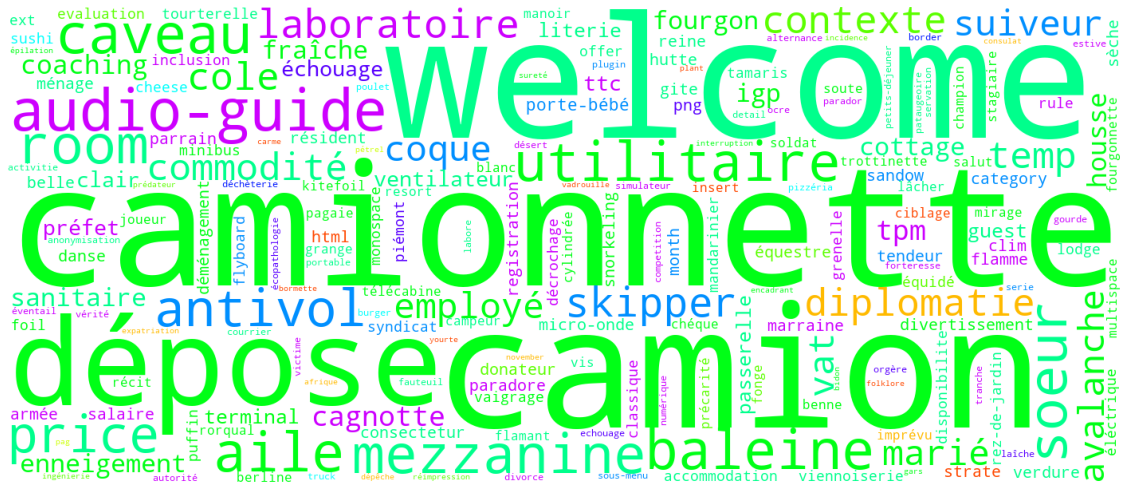

In [ ]:
# 2e méthode  
seuil1 = 1
seuil2 = 15
tempo = dict()
for cat in catGram:
  tempo[cat] = dict() # reconstruction du compteur de mots qui contiendra les mots à représenter et leur occ
  for ndf in CountMots.keys():
      for mot in diff[ndf][cat]:
        if mot in CountMots [ndf][cat].keys():
          if CountMots[ndf][cat][mot] > seuil1 and CountMots[ndf][cat][mot] < seuil2 : # en mettant inférieur --> signaux faibles
                                                  # en mettant supérieur --> signaux forts ou évidents
                                                  # écrétage entre seuil1 et 2
            tempo[cat][mot] = CountMots[ndf][cat][mot]
          else:
            pass
      #print (len(tempo.split()))
  if len(tempo[cat]) >0:
    makeImage2(tempo[cat], palette, couleursMots, leg = False) # true pour legend
  else:
    print("vide")
  print(cat)

## Représentations de la totalité des mots d'une catégorie sauf mots communs à tous

> en excluant les trivaux (occurrence maximale)

In [ ]:
aExclure += 'décembre novembre détail suite vendredi nov'.split()

In [ ]:
tempo = dict()
seuil = 0 # occurence à partir de laquelle démarrer

for ndf in RefdicoEtiquettage.keys():
  for cat in catGram:
    tempo[cat] = ""
    seuil2 = max([CountMots[ndf][cat][mot] for mot in CountMots[ndf][cat]]) #seuil
    for mot in CountMots[ndf][cat].keys():
      if CountMots[ndf][cat][mot] >seuil and CountMots[ndf][cat][mot] <seuil2 and mot not in aExclure and (mot in diff[ndf][cat] or mot in communs[ndf][cat]):
        tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
    print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    makeImage(tempo[cat], couleursMots, palette)